# Combined CNN-LSTM model

Importing batch data

In [1]:
from pymongo import MongoClient
import pandas as pd
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
tqdm.pandas()
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Dropout , Input , TimeDistributed , Dense , LSTM

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
#Estbalishing connection to the database
connection = MongoClient('localhost' , 27017)
db = connection['mydb']
collection = db['Batch_Data']

In [4]:
#Extracting the data

cursor = collection.find({}) 
batch_df = pd.DataFrame(list(cursor))

In [5]:
batch_df.head()

,_id,landmarks,label
0,6729ae6b068e5f1de5e9010e,"[{'face': [[0.528167724609375, 0.2578373367231...",book
1,6729ae6b068e5f1de5e9010f,"[{'face': [[0.242395827902416, 0.2020864317403...",book
2,6729ae6b068e5f1de5e90110,"[{'face': [[0.4664744738874764, 0.219961448490...",book
3,6729ae6b068e5f1de5e90111,"[{'face': [[0.479362738886966, 0.2433891842543...",book
4,6729ae6b068e5f1de5e90112,"[{'face': [[0.492517174267378, 0.0870498852922...",book


In [6]:
len(batch_df['landmarks'][0])

30

In [7]:

#converting the string values into numeric values

label_encoder = LabelEncoder()
batch_df['label_encoded'] = label_encoder.fit_transform(batch_df['label'])


In [8]:
batch_df

,_id,landmarks,label,label_encoded
0,6729ae6b068e5f1de5e9010e,"[{'face': [[0.528167724609375, 0.2578373367231...",book,1
1,6729ae6b068e5f1de5e9010f,"[{'face': [[0.242395827902416, 0.2020864317403...",book,1
2,6729ae6b068e5f1de5e90110,"[{'face': [[0.4664744738874764, 0.219961448490...",book,1
3,6729ae6b068e5f1de5e90111,"[{'face': [[0.479362738886966, 0.2433891842543...",book,1
4,6729ae6b068e5f1de5e90112,"[{'face': [[0.492517174267378, 0.0870498852922...",book,1
...,...,...,...,...
95,6729ae6b068e5f1de5e9016d,"[{'face': [[0.09501079164702321, 0.16571470140...",candy,2
96,6729ae6b068e5f1de5e9016e,"[{'face': [[0.20198555292371412, 0.22020006891...",candy,2
97,6729ae6b068e5f1de5e9016f,"[{'face': [[0.08536609051099148, 0.21951115430...",candy,2
98,6729ae6b068e5f1de5e90170,"[{'face': [[0.5128556353301399, 0.295628729619...",candy,2


Reshaping the Landmarks to align all the landmarks

In [9]:
def reshape_landmarks(record):

 iterations = len(record)
 
 concatenated_one_video = []

 for count in range(iterations):
 
    face_lands = np.array(record[count]['face'])
    left_hand_lands = np.array(record[count]['left_hand'])
    right_hand_lands = np.array(record[count]['right_hand'])

    #Concatinating all the landmarks to the shape (510 , 3)

    all_landmarks = np.vstack([face_lands , left_hand_lands , right_hand_lands]) # concatenated landmarks for 1 frame of the video

    concatenated_one_video.append(all_landmarks)
 
 return np.array(concatenated_one_video)

In [10]:
batch_df['concatenated_landmarks'] = batch_df['landmarks'].progress_apply(reshape_landmarks)

100%|██████████| 100/100 [00:00<00:00, 222.70it/s]


In [11]:
batch_df.head()

,_id,landmarks,label,label_encoded,concatenated_landmarks
0,6729ae6b068e5f1de5e9010e,"[{'face': [[0.528167724609375, 0.2578373367231...",book,1,"[[[0.528167724609375, 0.25783733672313774, -0...."
1,6729ae6b068e5f1de5e9010f,"[{'face': [[0.242395827902416, 0.2020864317403...",book,1,"[[[0.242395827902416, 0.20208643174030372, -0...."
2,6729ae6b068e5f1de5e90110,"[{'face': [[0.4664744738874764, 0.219961448490...",book,1,"[[[0.4664744738874764, 0.21996144849046956, -0..."
3,6729ae6b068e5f1de5e90111,"[{'face': [[0.479362738886966, 0.2433891842543...",book,1,"[[[0.479362738886966, 0.2433891842543816, -0.0..."
4,6729ae6b068e5f1de5e90112,"[{'face': [[0.492517174267378, 0.0870498852922...",book,1,"[[[0.492517174267378, 0.08704988529227371, -0...."


In [12]:
#Defining the number of labels

labels_count = len(batch_df['label'].unique())

In [13]:
labels_count

9

In [14]:
batch_df['concatenated_landmarks'].progress_apply(lambda row : (row).shape )

100%|██████████| 100/100 [00:00<00:00, 99367.54it/s]


0     (30, 510, 3)
1     (30, 510, 3)
2     (30, 510, 3)
3     (30, 510, 3)
4     (30, 510, 3)
          ...     
95    (30, 510, 3)
96    (30, 510, 3)
97    (30, 510, 3)
98    (30, 510, 3)
99    (30, 510, 3)
Name: concatenated_landmarks, Length: 100, dtype: object

In [15]:
#Resphaing the data to apply conv2D filter on the input data
batch_df['concatenated_landmarks'] = batch_df['concatenated_landmarks'].progress_apply(lambda row : row.reshape(30 , 510 , 3 , 1) )

100%|██████████| 100/100 [00:00<?, ?it/s]


In [16]:
batch_df['concatenated_landmarks'][88].shape

(30, 510, 3, 1)

In [17]:
one_hot_encoded_labels = tf.keras.utils.to_categorical(batch_df['label_encoded'])

In [18]:
one_hot_encoded_labels

array([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0.

Splitting the Data into Train and Test set

In [19]:
X = batch_df['concatenated_landmarks']
Y = one_hot_encoded_labels

# using 75 - 25 train - test split

X_train , X_test , Y_train , Y_test = train_test_split(X , Y , test_size= 0.25 , shuffle= True , random_state= 42 )

In [20]:
np.array(X_train.tolist()).shape

(75, 30, 510, 3, 1)

In [21]:
X_train = np.array(X_train.tolist())
X_test = np.array(X_test.tolist())

In [22]:
X_train[1  , 1 , 1 ]

array([[ 0.35349368],
       [ 0.20609774],
       [-0.04865456]])

In [23]:
print('The Shape of X-Train is:' , X_train.shape)
print('The Shape of X-Test is:' , X_test.shape)
print('The Shape of Y-Train is:' , Y_train.shape)
print('The Shape of Y-Test is:' , Y_test.shape)

The Shape of X-Train is: (75, 30, 510, 3, 1)
The Shape of X-Test is: (25, 30, 510, 3, 1)
The Shape of Y-Train is: (75, 9)
The Shape of Y-Test is: (25, 9)


In [24]:
Y_train

array([[0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0.

# Constructing LRCN Model
- We will use Time distributed **conv2D** layers followed by **Dropout** layers
- The feature extracted will then be flatnned using **flatten** layer and passed to **LSTM** layer
- Then **Dense** layer will use softmax activation to predict the action

In [25]:
def create_LRCN_model(): 

 """"
 This function will construct the required  LRCN model architecture. 

 Returns:
  model : Required LRCN model

 """

 # We will use a Sequential Model Architecture

 model = Sequential()

 # Defining the Model Architecture

 model.add(Input(shape=(30 , 510 ,3 ,1)))

 #CNN Layer 1
 model.add(TimeDistributed(Conv2D(filters= 16 , kernel_size= (3,3) , padding='same' , activation='relu')))
 # model.add(TimeDistributed(MaxPooling2D((1,2))))
 model.add(TimeDistributed(Dropout(0.25)))

  #CNN Layer 2
 model.add(TimeDistributed(Conv2D(filters= 32 , kernel_size= (3,3) , padding='same' , activation='relu')))
 # model.add(TimeDistributed(MaxPooling2D((1,2))))
 model.add(TimeDistributed(Dropout(0.25)))

  #CNN Layer 3
 model.add(TimeDistributed(Conv2D(filters= 64 , kernel_size= (3,3) , padding='same' , activation='relu')))
 # model.add(TimeDistributed(MaxPooling2D((1,2))))
 model.add(TimeDistributed(Dropout(0.25)))
 
   #CNN Layer 4
 model.add(TimeDistributed(Conv2D(filters= 64 , kernel_size= (3,3) , padding='same' , activation='relu')))
 # model.add(TimeDistributed(MaxPooling2D((1,2))))
 # model.add(TimeDistributed(Dropout(0.25)))

 model.add(TimeDistributed(Flatten()))

 # Feeding the extracted features to the LSTM layers

 model.add(LSTM(32))

 #Adding dese layer for classification 

 model.add(Dense(labels_count , activation='softmax' ))

 #Display model summary

 model.summary()

 #Return the constructed LRCN model

 return model

Now we use the function **create_LRCN_model()** 

In [26]:
# construct the model

LRCN_model = create_LRCN_model()

print('Model Created Successfuly')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 30, 510, 3, 16) │           160 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 30, 510, 3, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 30, 510, 3, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 30, 510, 3, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 30, 510, 3, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 30, 510, 3, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 30, 510, 3, 64) │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 30, 97920)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │    12,537,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,598,505 (48.06 MB)

 Trainable params: 12,598,505 (48.06 MB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfuly


Creating model structure

In [27]:
#Plot the structure of the constructed LRCN model
plot_model(LRCN_model , to_file='LRCN_model_structure_plot.png' , show_shapes=True , show_layer_names= True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


Compiling and Training the Model

In [28]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(
 monitor = 'val_loss',
 patience = 15 , 
 mode = 'min',
 restore_best_weights = True
)

#Compile the Model and Specify loss function , optimizer and metrics to the model
LRCN_model.compile(
 loss='categorical_crossentropy',
 optimizer = 'Adam', 
 metrics =["accuracy"]
 )

#Start training the model
LRCN_model_history = LRCN_model.fit(
 x= X_train , 
 y = Y_train , 
 epochs = 70 , 
 batch_size= 16 , 
 shuffle = True,
 validation_split = 0.2,
 callbacks = [early_stopping_callback]
 )

Epoch 1/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 109s 23s/step - accuracy: 0.1963 - loss: 2.2405 - val_accuracy: 0.0667 - val_loss: 2.3319
Epoch 2/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 91s 22s/step - accuracy: 0.2300 - loss: 2.0546 - val_accuracy: 0.0667 - val_loss: 2.2937
Epoch 3/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 89s 22s/step - accuracy: 0.1717 - loss: 2.0373 - val_accuracy: 0.1333 - val_loss: 2.2329
Epoch 4/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 86s 21s/step - accuracy: 0.2846 - loss: 1.9720 - val_accuracy: 0.1333 - val_loss: 2.2380
Epoch 5/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 93s 23s/step - accuracy: 0.3654 - loss: 1.8630 - val_accuracy: 0.1333 - val_loss: 2.2920
Epoch 6/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 91s 21s/step - accuracy: 0.3617 - loss: 1.7789 - val_accuracy: 0.1333 - val_loss: 2.3487
Epoch 7/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 87s 21s/step - accuracy: 0.3913 - loss: 1.6560 - val_accuracy: 0.1333 - val_loss: 2.2875
Epoch 8/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 94s 23s/step - accuracy: 0.3979 - loss: 1.5681 - val_accuracy: 0.0667 - val_loss: 2.4977

In [29]:
LRCN_model.evaluate(X_test , Y_test , verbose = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2000 - loss: 2.4432


[2.4432477951049805, 0.20000000298023224]

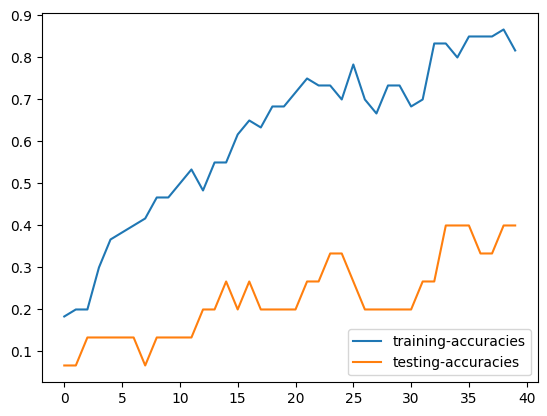

In [30]:
plt.plot(LRCN_model_history.history['accuracy'] , label = 'training-accuracies')
plt.plot(LRCN_model_history.history['val_accuracy'] , label ='testing-accuracies')
plt.legend(loc = 'lower right')

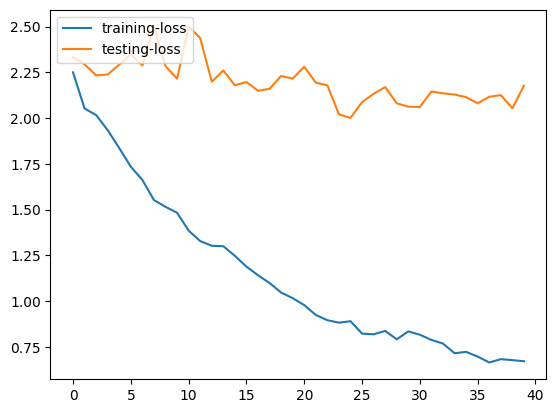

In [31]:
plt.plot(LRCN_model_history.history['loss'] , label = 'training-loss')
plt.plot(LRCN_model_history.history['val_loss'] , label ='testing-loss')
plt.legend(loc = 'upper left')